In [ ]:
# Uninstall and Install Required Libraries

In [ ]:
!pip uninstall -y transformers huggingface_hub accelerate tokenizers -q
!pip install transformers==4.41.1 datasets==2.19.1 evaluate accelerate -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Verify Installed Versions

In [1]:
import transformers
import torch
print("Transformers:", transformers.__version__)
print("Torch:", torch.__version__)


Transformers: 4.53.1
Torch: 2.6.0+cu124


In [ ]:
# Upload Dataset Files

In [2]:
from google.colab import files
uploaded = files.upload()


Saving test.txt to test.txt
Saving train.txt to train.txt
Saving val.txt to val.txt


In [ ]:
# Load and Preprocess Data

In [3]:
import pandas as pd

# Load the train, val, and test files
train_df = pd.read_csv("train.txt", sep=";", names=["text", "label"])
val_df = pd.read_csv("val.txt", sep=";", names=["text", "label"])
test_df = pd.read_csv("test.txt", sep=";", names=["text", "label"])

# Encode string labels to integers
labels = train_df['label'].unique()
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

train_df['label'] = train_df['label'].map(label2id)
val_df['label'] = val_df['label'].map(label2id)
test_df['label'] = test_df['label'].map(label2id)

print("Labels:", label2id)


Labels: {'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}


In [ ]:
# Exploratory Data Analysis

In [4]:
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))
train_df.head()


Train size: 16000
Validation size: 2000
Test size: 2000


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1


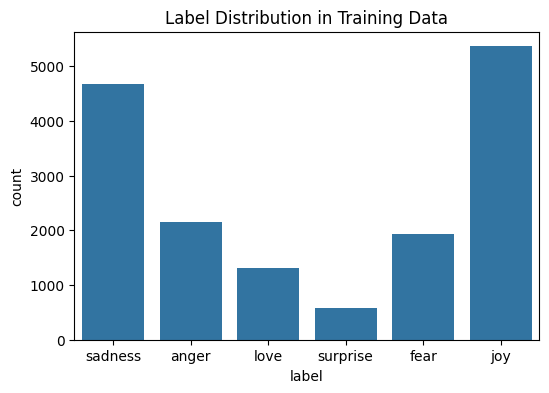

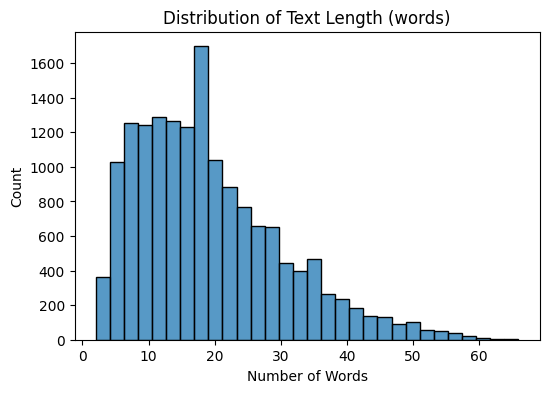

Average text length: 19.1663125
Missing values: text           0
label          0
text_length    0
text_len       0
dtype: int64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title("Label Distribution in Training Data")
plt.xticks(ticks=list(label2id.values()), labels=list(label2id.keys()))
plt.show()

# 2. Text length distribution
train_df["text_len"] = train_df["text"].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.histplot(train_df["text_len"], bins=30)
plt.title("Distribution of Text Length (words)")
plt.xlabel("Number of Words")
plt.show()

# 3. Basic stats
print("Average text length:", train_df['text_len'].mean())
print("Missing values:", train_df.isnull().sum())


In [ ]:
# Tokenize the Text Data

In [9]:
from transformers import AutoTokenizer
from datasets import Dataset

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Convert to Hugging Face datasets and tokenize
train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_dataset = Dataset.from_pandas(val_df).map(tokenize, batched=True)
test_dataset = Dataset.from_pandas(test_df).map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Load Pretrained BERT Model for Classification

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set Training Arguments

In [11]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"  # <== THIS disables wandb and all loggers
)


In [ ]:
# Define Evaluation Metrics

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
# Initialize Trainer and Start Training

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/tmp/ipython-input-14-2796941932.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
10,1.677500
20,1.610800
30,1.649000
40,1.514500
50,1.693000
60,1.650700
70,1.739300
80,1.436800
90,1.438500
100,1.345900


TrainOutput(global_step=6000, training_loss=0.2329682307820767, metrics={'train_runtime': 1090.0798, 'train_samples_per_second': 44.033, 'train_steps_per_second': 5.504, 'total_flos': 1970665688486592.0, 'train_loss': 0.2329682307820767, 'epoch': 3.0})

In [ ]:
#Evaluate on Validation Set

In [15]:
results = trainer.evaluate()
print(" Evaluation Results:")
print(results)


 Evaluation Results:
{'eval_loss': 0.19884558022022247, 'eval_accuracy': 0.937, 'eval_f1': 0.9366835635752779, 'eval_precision': 0.9368637302572206, 'eval_recall': 0.937, 'eval_runtime': 9.2373, 'eval_samples_per_second': 216.514, 'eval_steps_per_second': 27.064, 'epoch': 3.0}


In [ ]:
# Display Confusion Matrix

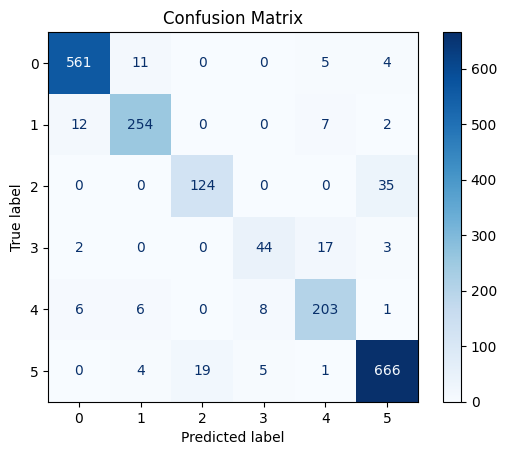

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Set Human-Readable Label Mappings

In [22]:
model.config.id2label = id2label
model.config.label2id = label2id


In [ ]:
# Save Model and Tokenizer

In [23]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

In [ ]:
# List Available Checkpoints

In [24]:
import os

checkpoints = [f for f in os.listdir("./results") if f.startswith("checkpoint")]
print("Available checkpoints:", checkpoints)


Available checkpoints: ['checkpoint-2000', 'checkpoint-5000', 'checkpoint-500', 'checkpoint-1500', 'checkpoint-5500', 'checkpoint-2500', 'checkpoint-4500', 'checkpoint-3500', 'checkpoint-6000', 'checkpoint-4000', 'checkpoint-1000', 'checkpoint-3000']


In [ ]:
# Load Model from Checkpoint for Inference

In [25]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# checkpoint folder name
checkpoint_path = "./results/checkpoint-500"

tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Set up the inference pipeline
inference_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)


Device set to use cuda:0


In [ ]:
# Run Inference on Sample Inputs

In [26]:
sample_texts = [
    "I absolutely loved the performance — it was inspiring!",
    "What a complete waste of time. The story made no sense.",
    "The product was okay, not great but not terrible either.",
    "I'm never coming back to this place again. Horrible service.",
    "That concert last night was phenomenal!",
    "I'm really disappointed. I expected much better.",
    "The app crashes every time I try to open it. Very annoying.",
    "Such a pleasant surprise — exceeded my expectations.",
    "Nothing special. It's just average.",
    "It’s the best thing I've ever purchased!"
]

results = inference_pipeline(sample_texts)

for text, pred in zip(sample_texts, results):
    print(f"Input: {text}\nPrediction: {pred}\n")


Input: I absolutely loved the performance — it was inspiring!
Prediction: {'label': 'joy', 'score': 0.9037138223648071}

Input: What a complete waste of time. The story made no sense.
Prediction: {'label': 'sadness', 'score': 0.3740358054637909}

Input: The product was okay, not great but not terrible either.
Prediction: {'label': 'joy', 'score': 0.9810086488723755}

Input: I'm never coming back to this place again. Horrible service.
Prediction: {'label': 'sadness', 'score': 0.9894905686378479}

Input: That concert last night was phenomenal!
Prediction: {'label': 'joy', 'score': 0.9760408997535706}

Input: I'm really disappointed. I expected much better.
Prediction: {'label': 'joy', 'score': 0.9730526208877563}

Input: The app crashes every time I try to open it. Very annoying.
Prediction: {'label': 'anger', 'score': 0.8883394598960876}

Input: Such a pleasant surprise — exceeded my expectations.
Prediction: {'label': 'joy', 'score': 0.9829760193824768}

Input: Nothing special. It's ju

In [ ]:
# Zip and Download the Saved Model

In [ ]:
import shutil
shutil.make_archive('saved_model', 'zip', './saved_model')
from google.colab import files
files.download('saved_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot Training and Validation Loss Curve

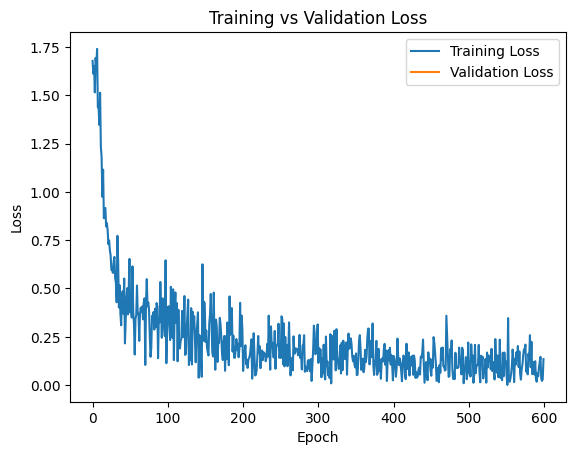

In [27]:
import matplotlib.pyplot as plt

# Example: using trainer.state.log_history
logs = trainer.state.log_history

train_loss = [x['loss'] for x in logs if 'loss' in x]
eval_loss = [x['eval_loss'] for x in logs if 'eval_loss' in x]

plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()
